# astroVIPER Installation Test

```python
conda create --name astroviper python=3.11 --no-default-packages
conda activate astroviper
#Only on mac: conda install -c conda-forge python-casacore
pip install astroviper
```

## Check installation

In [1]:
import os

from importlib.metadata import version

try:
    import astroviper

    print("astroVIPER version", version("astroviper"), "already installed.")
except ImportError as e:
    print(e)
    print("Installing astroVIPER")

    os.system("pip install astroviper")

    import xradio

    print("astroVIPER version", version("astroviper"), " installed.")

astroVIPER version 0.0.5 already installed.


## Optional if casarc does not have path to casadata

In [2]:
"""
import pkg_resources
casa_data_dir = pkg_resources.resource_filename('casadata', '__data__')
rc_file = open(os.path.expanduser("~/.casarc"), "a+")  # append mode
rc_file.write("\n measures.directory: " + casa_data_dir)
rc_file.close()
"""

'\nimport pkg_resources\ncasa_data_dir = pkg_resources.resource_filename(\'casadata\', \'__data__\')\nrc_file = open(os.path.expanduser("~/.casarc"), "a+")  # append mode\nrc_file.write("\n measures.directory: " + casa_data_dir)\nrc_file.close()\n'

## Setup Dask Cluster

In [3]:
import astroviper
from astroviper.client import local_client

viper_client = local_client(cores=2, memory_limit="4GB", worker_log_parms=None)
viper_client

[client.py:115 -         local_client() ] Created client <Client: 'tcp://127.0.0.1:50228' processes=2 threads=2, memory=7.45 GiB>


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 2
Total threads: 2,Total memory: 7.45 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:50228,Workers: 2
Dashboard: http://127.0.0.1:8787/status,Total threads: 2
Started: Just now,Total memory: 7.45 GiB
Comm: tcp://127.0.0.1:50237,Total threads: 1
Dashboard: http://127.0.0.1:50240/status,Memory: 3.73 GiB
Nanny: tcp://127.0.0.1:50231,


## Download and convert dataset

In [4]:
from xradio.data.datasets import download

infile = "Antennae_North.cal.lsrk.split.ms"
outfile = "Antennae_North.cal.lsrk.split.vis.zarr"
download(file="Antennae_North.cal.lsrk.split.ms", source="dropbox")

from xradio.vis.convert_msv2_to_processing_set import convert_msv2_to_processing_set

partition_scheme = "ddi_intent_field"

chunks_on_disk = {"frequency": 3}
convert_msv2_to_processing_set(
    infile=infile,
    outfile=outfile,
    partition_scheme=partition_scheme,
    parallel=False,
    overwrite=True,
    chunks_on_disk=chunks_on_disk,
)

File exists.


## Inspect Processing Set

In [5]:
ps_name = outfile

from xradio.vis.read_processing_set import read_processing_set

# sel_parms = {'xds_id':[0,1,2]}
# fields = ["NGC4038 - Antennae North"]
intents = ["OBSERVE_TARGET#ON_SOURCE"]
fields = None
ps = read_processing_set(ps_name, intents=intents, fields=fields)
ps.summary()

,name,ddi,intent,field_id,field_name,start_frequency,end_frequency
0,Antennae_North.cal.lsrk.split_ddi_0_intent_OBS...,0,OBSERVE_TARGET#ON_SOURCE,1,NGC4038 - Antennae North,3.439281e+11,3.440067e+11
1,Antennae_North.cal.lsrk.split_ddi_0_intent_OBS...,0,OBSERVE_TARGET#ON_SOURCE,0,NGC4038 - Antennae North,3.439281e+11,3.440067e+11
2,Antennae_North.cal.lsrk.split_ddi_0_intent_OBS...,0,OBSERVE_TARGET#ON_SOURCE,2,NGC4038 - Antennae North,3.439281e+11,3.440067e+11


## Inspect a single ms_v4

In [6]:
ms_xds = ps[list(ps.keys())[0]]

## Creating Parallel Coordinates for the Map

### Example: Frequency Parallel Coordinate

In [7]:
from astroviper._concurrency._graph_tools import _make_parallel_coord

parallel_coords = {}
n_chunks = 3
parallel_coords["frequency"] = _make_parallel_coord(
    coord=ms_xds.frequency, n_chunks=n_chunks
)
parallel_coords["frequency"]

{'data': [343928096685.9587,
  343939328174.9401,
  343950559663.9216,
  343961791152.903,
  343973022641.88446,
  343984254130.8659,
  343995485619.84735,
  344006717108.8288],
 'data_chunks': {0: array([3.43928097e+11, 3.43939328e+11, 3.43950560e+11]),
  1: array([3.43961791e+11, 3.43973023e+11, 3.43984254e+11]),
  2: array([3.43995486e+11, 3.44006717e+11])},
 'dims': ('frequency',),
 'attrs': {'channel_width': {'attrs': {'type': 'quanta', 'units': ['Hz']},
   'data': 11231488.981445312,
   'dims': ''},
  'frame': 'LSRK',
  'reference_frequency': {'attrs': {'frame': 'LSRK',
    'type': 'spectral_coord',
    'units': ['Hz']},
   'data': 343928096685.9587,
   'dims': ''},
  'spectral_window_name': '',
  'spw_id': 0,
  'type': 'spectral_coord',
  'units': ['Hz']}}

## Create a chunk function and map graph

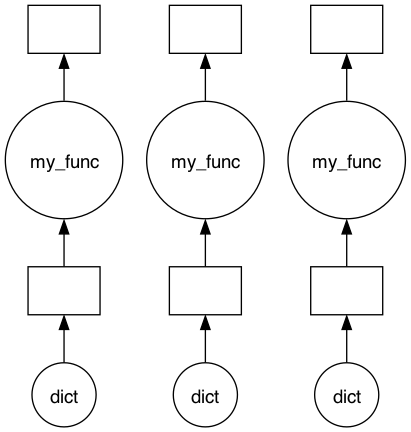

In [8]:
from astroviper._concurrency._graph_tools import _map
import dask


def my_func(input_parms):
    print("Keys in input parameters: ", list(input_parms.keys()))
    print("Test_input:", input_parms["test_input"])
    print("data_sel", input_parms["data_sel"])
    print("chunk_coords", input_parms["chunk_coords"])
    print("chunk_id", input_parms["chunk_id"])
    print("*****" * 10)
    return input_parms["test_input"]


# ['test_input', 'input_data_name', 'viper_local_dir', 'date_time', 'data_sel', 'chunk_coords', 'chunk_indx', 'chunk_id', 'parallel_dims']
input_parms = {}
input_parms["test_input"] = 42

sel_parms = {}
sel_parms["fields"] = ["NGC4038 - Antennae North"]
sel_parms["intents"] = ["OBSERVE_TARGET#ON_SOURCE"]
graph = _map(
    input_data_name=ps_name,
    input_data_type="processing_set",
    ps_sel_parms=sel_parms,
    parallel_coords=parallel_coords,
    func_chunk=my_func,
    input_parms=input_parms,
    client=None,
)

dask.visualize(graph)

## Run the graph

In [9]:
dask.compute(graph)

(([42, 42, 42], None),)

## Adding a reduce

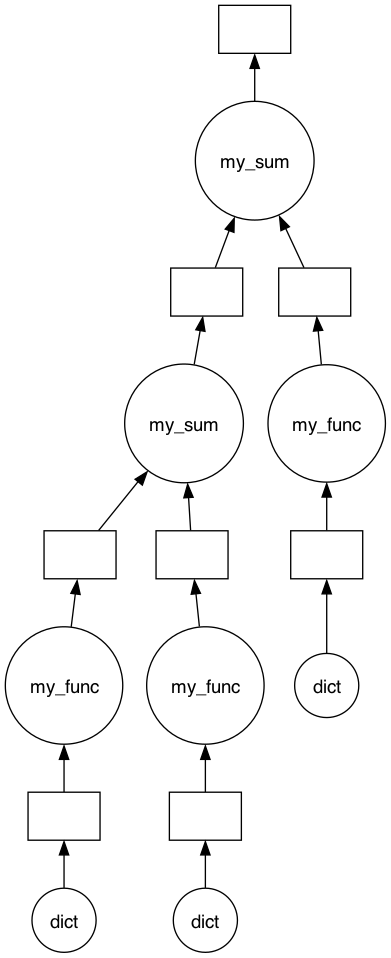

In [10]:
from astroviper._concurrency._graph_tools import _reduce


def my_sum(input_data, input_parms):
    return np.sum(input_data) + input_parms["test_input"]


input_parms = {}
input_parms["test_input"] = 5
graph_reduce = _reduce(graph, my_sum, input_parms)
dask.visualize(graph_reduce)

## Run the graph

In [11]:
dask.compute(graph_reduce)

2023-10-24 22:50:29,499 - distributed.worker - WARNING - Compute Failed
Key:       my_sum-13cc6090-f2e6-4dc8-b56b-3b2f7121d8da
Function:  execute_task
args:      ((<function my_sum at 0x115e8fa60>, [42, 42], (<class 'dict'>, [['test_input', 5]])))
kwargs:    {}
Exception: 'NameError("name \'np\' is not defined")'



NameError: name 'np' is not defined